# A Time Series Analysis on Wikipedia Site Traffic

This is a Python revision of my Wikipedia site traffic analysis, which was originally implemented in R. Wikipedia is a great subject of statistical modeling with enormous influx of traffic, and most data can be requested in real time from their public API. However, due to limitations of R language, we were unable to take advantage of all the data out there. This homework is supposed to make up for my regret. Specifically, I'll use Spark to 1) make real-time API requests to query large volumns of Wikipedia pageviews, 2) automate EDA using matplotlib, and 3) fit a time series model to the data.



## System Setup

In [0]:
# install spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.6.tgz
!tar xf spark-2.4.5-bin-hadoop2.6.tgz
!pip install -q findspark
# install package for time series analysis
!pip install pmdarima

In [0]:
# set environment variables and intialize a spark session
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.6"

import findspark
findspark.init("spark-2.4.5-bin-hadoop2.6")

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Exploratory Data Analysis

In [0]:
import json
import numpy as np
import pandas as pd
import requests as req
import matplotlib.pyplot as plt
plt.rcParams['axes.titlesize'] = 16

################### FUNCTIONS #####################

def url2json(url):
    """request json data from url"""
    resp = req.get(url)
    df = pd.DataFrame(resp.json()['items'])
    # convert timestamp to yyyymmdd
    df['timestamp'] = df['timestamp'].map(lambda x: x[:-2])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.rename(columns={'timestamp': 'date'})
    return df

def plot_two(df1, df2, title='legacy vs modern count'):
    """plot time series of traffic (2 types)
    df1: legacy
    df2: modern
    """
    ax = plt.gca()
    df1.plot(x='date', y='count', color='lightblue', linewidth=1.5, label='legacy', ax=ax)
    df2.plot(x='date', y='views', color='steelblue', linewidth=1.5, label='modern', ax=ax)
    plt.ylabel('count')
    plt.title(title)
    plt.legend(loc="upper left")
    plt.show()

################### DATA #####################
# Project:      en.wikipedia.org
# Access:       all (desktop+mobile)
# Granularity:  daily
# Start:        20150701-00
# End:          20160801-23

url_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/all-sites/daily/2015070100/2016080123'
url_pageview_all = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/all-agents/daily/2015070100/2016080123'
url_pageview_user = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/user/daily/2015070100/2016080123'
url_pageview_spider = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/spider/daily/2015070100/2016080123'

Head of the legacy page count data:

In [0]:
# read legacy
df1 = url2json(url_legacy)
pd.DataFrame(df1).head()

,project,access-site,granularity,date,count
0,en.wikipedia,all-sites,daily,2015-07-01,259947127
1,en.wikipedia,all-sites,daily,2015-07-02,268181307
2,en.wikipedia,all-sites,daily,2015-07-03,251058920
3,en.wikipedia,all-sites,daily,2015-07-04,250088802
4,en.wikipedia,all-sites,daily,2015-07-05,260283030


Head of the modern pageview data:

In [0]:
# read modern
df2 = url2json(url_pageview_user)
pd.DataFrame(df2).head()

,project,access,agent,granularity,date,views
0,en.wikipedia,all-access,user,daily,2015-07-01,243497551
1,en.wikipedia,all-access,user,daily,2015-07-02,241866978
2,en.wikipedia,all-access,user,daily,2015-07-03,226919786
3,en.wikipedia,all-access,user,daily,2015-07-04,226583272
4,en.wikipedia,all-access,user,daily,2015-07-05,240912348


Visual comparison of the two metrics reveals that legacy pagecounts and modern pageviews maintain a constant relationship over time.

---



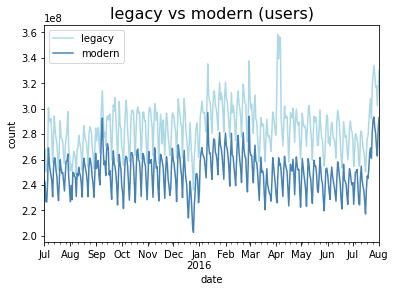

In [0]:
plot_two(df1, df2, 'legacy vs modern (users)')

The main difference between legacy pagecounts and modern pageviews can be attributed to robot visits. After adding robot visits back to modern pageviews, the two metrics are almost identical as shown in the plot below.

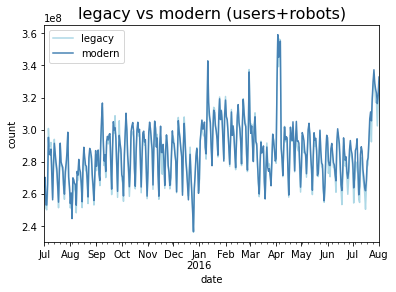

In [0]:
df3 = url2json(url_pageview_all)
plot_two(df1, df3, 'legacy vs modern (users+robots)')

## Modeling

Fit an ARIMA model to legacy pagecounts. The best model found in terms of AIC is ARIMA(4,1,5).

In [0]:
from pmdarima.arima import auto_arima
from pmdarima import model_selection

df1.index = df1['date']
# model selection
model = auto_arima(df1['count'], seasonal=True, suppress_warnings=True, error_action='ignore')
model

ARIMA(maxiter=50, method='lbfgs', order=(4, 1, 5), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

Now we can assess the performance of the model and make forecasts.

Text(0.5, 1.0, 'traffic forecasts')

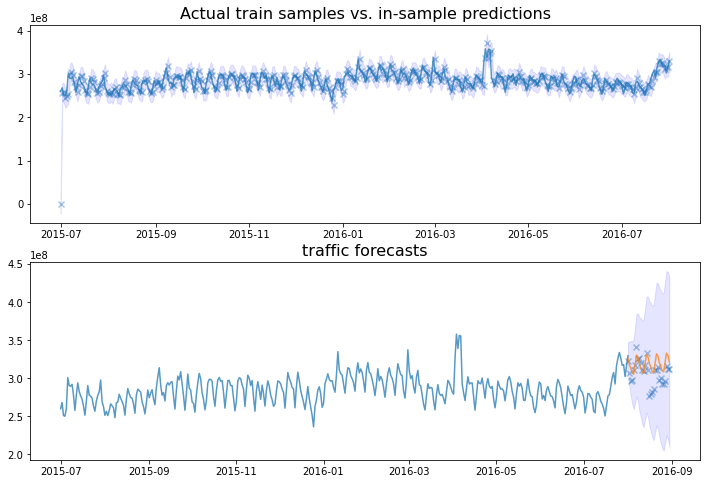

In [0]:
import datetime

# get in-sample predictions and CIs
in_sample_preds, in_sample_confint = model.predict_in_sample(exogenous=None, return_conf_int=True)
# create predictions for the future
preds, conf_int = model.predict(n_periods=30, return_conf_int=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# plot fitted vs observed
axes[0].plot(df1['date'], df1['count'], alpha=0.75)
axes[0].scatter(df1['date'], in_sample_preds, alpha=0.4, marker='x')
axes[0].fill_between(df1['date'], in_sample_confint[:, 0], in_sample_confint[:, 1],
                     alpha=0.1, color='b')
axes[0].set_title('Actual train samples vs. in-sample predictions')

# plot forecast with CIs
xdate = [df1['date'][i] for i in range(len(df1['date']))] + [df1['date'][-1] + datetime.timedelta(days=x) for x in range(30)]
test_pageview = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/all-access/all-agents/daily/2016080200/2016083100'
df4 = url2json(test_pageview)
axes[1].plot(df1['date'], df1['count'], alpha=0.75)
axes[1].plot(xdate[df1.shape[0]:], preds, alpha=0.75)  # Forecasts
axes[1].scatter(xdate[df1.shape[0]:], df4['views'], alpha=0.4, marker='x')
axes[1].fill_between(xdate[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b')
axes[1].set_title("traffic forecasts")

The first plot above visualizes the actual training sample against in-sample predictions from the ARIMA model. We can see a nice match from the plot, as most observed values fall within the confidence interval.

The second plot visualizes the forecast of Wikipedia traffic in the next 30 days. Note that the yellow curve is an average of all possible simulations from the model, so it seems quite smooth in the plot. The actual traffic is labeled 'x' in the plot. Again, all observed values fall within the confidence interval. Therefore the model does a decent job in capturing the trends of Wikipedia site traffic.